In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from probly.quantification.classification import mutual_information
from probly.representation import Ensemble
from probly.tasks import out_of_distribution_detection

### Load data and create neural network

In [2]:
transforms = T.Compose([T.ToTensor(), torch.flatten])

train = torchvision.datasets.FashionMNIST(
    root="~/datasets/", train=True, download=True, transform=transforms
)
test = torchvision.datasets.FashionMNIST(
    root="~/datasets/", train=False, download=True, transform=transforms
)
train_loader = DataLoader(train, batch_size=256, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=False)

ood = torchvision.datasets.MNIST(
    root="~/datasets/", train=False, download=True, transform=transforms
)
ood_loader = DataLoader(ood, batch_size=256, shuffle=False)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

### Make neural network a dropout model

In [3]:
ensemble = Ensemble(Net(), 5)

### Train each ensemble member as usual

In [4]:
criterion = nn.CrossEntropyLoss()
for model in tqdm(ensemble.models):
    optimizer = optim.Adam(model.parameters())
    for _ in range(10):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# compute accuracy on test set
correct = 0
total = 0
ensemble.eval()
for inputs, targets in test_loader:
    outputs = ensemble(inputs).mean(axis=1)
    correct += (outputs.argmax(1) == targets).sum().item()
    total += targets.size(0)
print(f"Accuracy: {correct / total}")

100%|██████████| 5/5 [01:24<00:00, 16.96s/it]


Accuracy: 0.881


### Compute epistemic uncertainty for in-distribution (FashionMNIST) and out-of-distribution (MNIST) data

In [5]:
@torch.no_grad()
def torch_get_outputs(model, loader):
    outputs = torch.empty(0)
    for data, _ in loader:
        outputs = torch.cat((outputs, model(data)), dim=0)
    return outputs


# get all outputs
outputs_id = torch_get_outputs(ensemble, test_loader)
outputs_ood = torch_get_outputs(ensemble, ood_loader)
outputs_id = F.softmax(outputs_id, dim=2).numpy()
outputs_ood = F.softmax(outputs_ood, dim=2).numpy()

# compute uncertainties
uncertainty_id = mutual_information(outputs_id)
uncertainty_ood = mutual_information(outputs_ood)

### Do Out-of-Distribution task

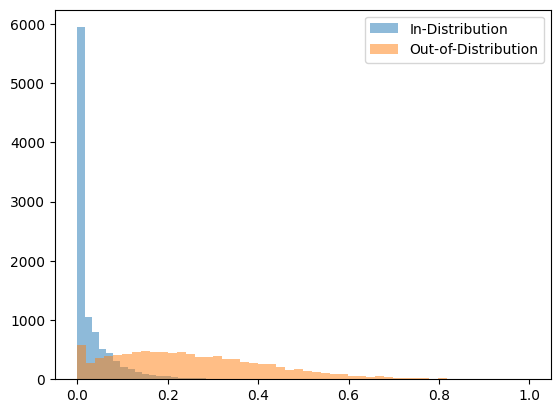

AUROC with FashionMNIST as iD and MNIST as OoD: 0.924


In [6]:
# plot the uncertainties in a histogram
plt.hist(uncertainty_id, bins=50, alpha=0.5, label="In-Distribution")
plt.hist(uncertainty_ood, bins=50, alpha=0.5, label="Out-of-Distribution")
plt.legend()
plt.show()

auroc = out_of_distribution_detection(uncertainty_id, uncertainty_ood)
print(f"AUROC with FashionMNIST as iD and MNIST as OoD: {auroc:.3f}")